In [86]:
#https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [1]:
from gtfparse import read_gtf
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler

from lifelines import CoxPHFitter
from lifelines.utils.printer import Printer

%matplotlib inline

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
dataset = pd.read_pickle("genes_2183.pkl")

In [3]:
dataset

gene_id,A1CF,A4GALT,A4GNT,AACS,AADAC,AADAT,AASDH,AASDHPPT,AASS,ABAT,...,VKORC1,VKORC1L1,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2,time,status
0,327.580024,4.565263,1.503392,12.572493,1805.123528,17.002015,11.552261,217.597635,87.000796,193.012594,...,392.847768,50.542797,82.711193,81.331374,1.308525,23.424147,90.170078,280.955929,1219,1.0
1,277.993195,4.569869,2.895887,40.028381,715.065094,10.587053,30.182355,87.893141,15.342392,71.398113,...,1076.825827,56.229376,71.201324,21.310214,5.135460,50.208414,66.353808,474.279722,538,1.0
2,129.493501,13.134280,-1.130063,4.798694,1461.123349,23.075056,9.003491,105.145072,79.464835,173.672689,...,1529.361260,21.157264,13.728403,14.569620,1.182746,13.800796,81.856447,103.632650,211,1.0
3,171.382339,5.944686,-1.130063,3.683432,2492.189076,30.375204,3.575955,83.402545,136.891997,186.029184,...,1234.278841,23.517800,169.796421,30.994313,1.789428,32.291904,70.663530,83.408259,9,1.0
4,213.377844,21.237178,-1.130063,8.265827,1694.378189,17.630500,16.007001,88.856381,14.632866,253.035994,...,2439.449698,25.128027,77.757799,61.747736,3.717348,19.575849,80.099674,149.332493,601,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,5.975748,50.825808,4.285170,12.523481,-240.990008,-2.483306,16.094313,147.720103,-2.620187,2.035854,...,807.526151,37.964067,7.916621,2.194635,13.764792,18.536899,97.960197,252.651616,1080,1.0
599,174.365200,23.501875,3.232084,21.621618,1610.067465,41.050697,18.785534,171.686330,6.968554,135.138792,...,1822.297763,37.575333,18.875453,104.139793,0.760138,39.263981,97.017666,337.301206,1110,1.0
600,339.523976,5.507910,0.638759,15.440387,5198.351456,12.519955,18.856227,139.207263,81.918175,168.744628,...,939.899602,20.415830,13.904091,34.100246,0.494743,17.450417,29.995134,107.879231,930,1.0
601,126.096442,4.353566,0.999106,12.581200,925.355154,46.172985,8.217365,57.830954,697.850186,164.114659,...,406.449099,45.125643,30.863681,36.956954,0.472793,19.043588,41.644671,88.693079,780,0.0


In [229]:
X = dataset.iloc[:,:-2].to_numpy()/1000

In [230]:
y = dataset.iloc[:,-1].values

colors=[]
for i in y:
    if i==1:
        colors.append("red")
    else:
        colors.append("green")
        
print(len(colors))

601


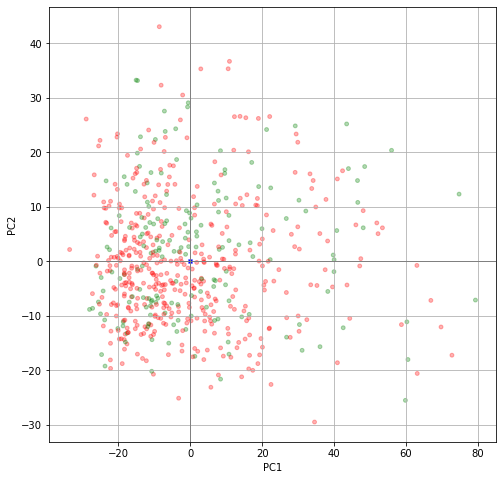

In [231]:
fig, ax = plt.subplots(figsize=(8,8))

pca = sklearnPCA(n_components=2)

X_s = StandardScaler().fit_transform(X)

Y = pca.fit_transform(X_s)

x1 = Y[:,0]
y1 = Y[:,1]

mu_x1 = np.mean(x1)
mu_y1 = np.mean(y1)
    
ax.scatter(x1, y1, s=15,color = colors,alpha=0.3)
#confidence_ellipse(x1, y1, ax,n_std=1, edgecolor='blue')
ax.scatter(mu_x1, mu_y1, c='blue', s=15,marker="x")

ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()

plt.show()

# ALGORITHM

In [393]:
# https://towardsdatascience.com/building-our-first-neural-network-in-keras-bdc8abbc17f5

In [112]:
X = X_s
y = dataset.iloc[:,-1].values

In [113]:
np.shape(X),np.shape(y)

((601, 2181), (601,))

In [114]:
X_train = X
y_train = y

In [198]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [251]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense# Neural network
model = Sequential()
model.add(Dense(200, input_dim=2181, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(1, activation="softmax"))

In [252]:
#from keras.optimizers import SGD
#opt = SGD(lr=0.01)
#model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy'])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [253]:
import time

t0 = time.process_time()


hist = model.fit(X_train, y_train,epochs=5,batch_size=1,validation_data=(X_test, y_test),verbose=1)


t_elapsed = time.process_time() - t0
print("Elapsed time =",t_elapsed)


print(hist.history['loss'])
print(hist.history['val_loss'])

print("acc",hist.history['accuracy'])
print("val_acc",hist.history['val_accuracy'])

#result = net.evaluate(x_val, y_val, batch_size=25)
#accuracy.append(result[1])

Epoch 1/5
420/420 [==============================] - 1s 1ms/step - loss: 0.7049 - accuracy: 0.7088 - val_loss: 0.6842 - val_accuracy: 0.7569
Epoch 2/5
420/420 [==============================] - 0s 1ms/step - loss: 0.7533 - accuracy: 0.6332 - val_loss: 0.6323 - val_accuracy: 0.7569
Epoch 3/5
420/420 [==============================] - 0s 1ms/step - loss: 0.6130 - accuracy: 0.6642 - val_loss: 0.6611 - val_accuracy: 0.7569
Epoch 4/5
420/420 [==============================] - 0s 1ms/step - loss: 0.4363 - accuracy: 0.7422 - val_loss: 0.6185 - val_accuracy: 0.7569
Epoch 5/5
420/420 [==============================] - 0s 1ms/step - loss: 0.4669 - accuracy: 0.6793 - val_loss: 0.9375 - val_accuracy: 0.7569
Elapsed time = 10.316109422999943
[0.7216697931289673, 0.7013364434242249, 0.5678431391716003, 0.4889463484287262, 0.4611061215400696]
[0.684158980846405, 0.6322548985481262, 0.6610797047615051, 0.6184785962104797, 0.9375006556510925]
acc [0.6928571462631226, 0.6928571462631226, 0.6928571462631

In [254]:
history = hist

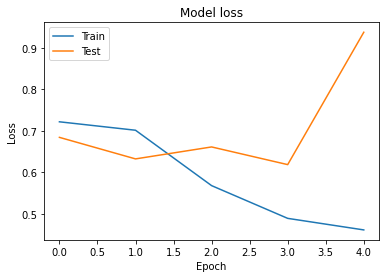

In [255]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

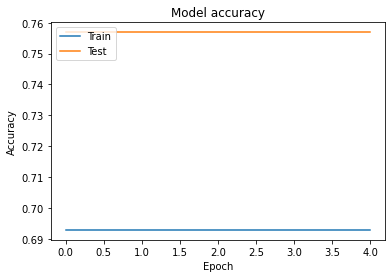

In [256]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Random Forest

In [241]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
X_, y_ = make_classification(n_samples=1000, n_features=4,n_informative=2, 
                           n_redundant=0,random_state=0, shuffle=False)

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_, y_)

print(clf.predict([[0, 0, 0, 0]]))

[1]


In [247]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_s,y,test_size = 0.3)

In [248]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [249]:
pred = clf.predict(X_test)

In [250]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,y_test)
print('Accuracy is:', a*100)

Accuracy is: 75.69060773480662


In [266]:
final_genes=pd.read_excel("mol212639-sup-0006-tables1-s11.xlsx",
                  sheet_name="Table S1")

df = final_genes

new_header = df.iloc[0]
df = df[1:]
df.columns = new_header

df

final_set = set(df["Gene Symbol"].tolist())

In [267]:
final_set.remove('PDE7B')

X_new = dataset[sorted(list(final_set))]

X_new

gene_id,AACS,AADAC,ABAT,ABCA10,ABCA3,ABCA6,ABCA8,ABCA9,ABCB11,ABCB4,...,UQCRH,UROC1,UROD,UXS1,VDAC1,VDAC2,VKORC1L1,XDH,XYLT2,ZACN
0,12.572493,1805.123528,193.012594,5.278493,4.579185,38.053828,15.792680,23.256634,11.815138,79.230857,...,469.908119,201.989621,1605.575292,70.044723,653.663789,273.725532,50.542797,82.711193,23.424147,90.170078
1,40.028381,715.065094,71.398113,13.074486,4.378362,81.091859,2.287736,4.272962,-0.606501,16.142701,...,716.596658,-9.697443,2352.093621,24.145315,546.982939,554.191792,56.229376,71.201324,50.208414,66.353808
2,4.798694,1461.123349,173.672689,2.811498,3.466815,108.328409,41.102122,4.815614,11.873980,143.774931,...,318.713261,63.452457,1926.775358,15.226942,290.342036,145.023418,21.157264,13.728403,13.800796,81.856447
3,3.683432,2492.189076,186.029184,5.080452,2.312352,195.240464,51.742970,10.280747,48.384458,260.199508,...,746.736299,101.086346,2381.482679,23.565192,441.114398,128.765207,23.517800,169.796421,32.291904,70.663530
4,8.265827,1694.378189,253.035994,3.013636,6.283878,78.270430,76.314462,9.452828,27.419865,197.475563,...,309.669770,123.249054,3151.171162,21.648266,539.588554,312.346044,25.128027,77.757799,19.575849,80.099674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,12.523481,-240.990008,2.035854,1.309743,10.061788,29.730780,2.596580,5.206152,-3.009368,8.236466,...,705.821647,11.829312,2882.933891,34.088720,770.638145,398.263015,37.964067,7.916621,18.536899,97.960197
599,21.621618,1610.067465,135.138792,-1.566092,-4.195922,74.590516,152.284053,8.555587,3.611249,24.406617,...,960.447487,12.500758,3625.023103,57.514106,1008.705439,215.510492,37.575333,18.875453,39.263981,97.017666
600,15.440387,5198.351456,168.744628,-0.997042,9.041737,154.618928,86.295653,9.450086,1.091557,103.174532,...,261.035796,12.481717,1678.999381,19.548182,286.449850,150.630730,20.415830,13.904091,17.450417,29.995134
601,12.581200,925.355154,164.114659,-0.939174,-4.822648,264.422419,100.832049,-0.651941,170.233159,61.757618,...,353.321035,29.324475,851.724126,24.183058,511.540081,118.440826,45.125643,30.863681,19.043588,41.644671


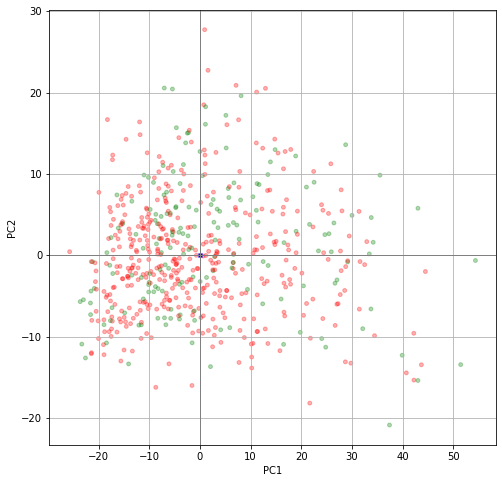

In [268]:
fig, ax = plt.subplots(figsize=(8,8))

pca = sklearnPCA(n_components=2)

X_std = StandardScaler().fit_transform(X_new)

Y = pca.fit_transform(X_std)

x1 = Y[:,0]
y1 = Y[:,1]

mu_x1 = np.mean(x1)
mu_y1 = np.mean(y1)
    
ax.scatter(x1, y1, s=15,color = colors,alpha=0.3)
#confidence_ellipse(x1, y1, ax,n_std=1, edgecolor='blue')
ax.scatter(mu_x1, mu_y1, c='blue', s=15,marker="x")

ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()

plt.show()

In [389]:
X = X_s
y = dataset.iloc[:,-1].values

array = y.reshape(-1, 1)

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(array).toarray()

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

In [390]:
print(np.shape(X_test),np.shape(y_test))

(121, 2181) (121, 2)


In [381]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense# Neural network
model = Sequential()
model.add(Dense(1000, input_dim=len(X_s[0]), activation="relu"))
model.add(Dense(200, activation="relu"))
model.add(Dense(2, activation="softmax"))

#model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy'])


from keras.optimizers import SGD
opt = SGD(lr=0.001)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])

import time

t0 = time.process_time()


hist = model.fit(X_train, y_train,epochs=10,batch_size=50,validation_data=(X_test, y_test),verbose=1)


t_elapsed = time.process_time() - t0
print("Elapsed time =",t_elapsed)


print(hist.history['loss'])
print(hist.history['val_loss'])

print("acc",hist.history['accuracy'])
print("val_acc",hist.history['val_accuracy'])

#result = net.evaluate(x_val, y_val, batch_size=25)
#accuracy.append(result[1])

Epoch 1/10
10/10 [==============================] - 0s 20ms/step - loss: 1.1622 - accuracy: 0.3448 - val_loss: 0.7560 - val_accuracy: 0.5124
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 0.7980 - accuracy: 0.4964 - val_loss: 0.6677 - val_accuracy: 0.6116
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 0.7167 - accuracy: 0.6103 - val_loss: 0.6412 - val_accuracy: 0.6529
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 0.6588 - accuracy: 0.6534 - val_loss: 0.6283 - val_accuracy: 0.6777
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 0.6112 - accuracy: 0.7135 - val_loss: 0.6222 - val_accuracy: 0.6860
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 0.6148 - accuracy: 0.7068 - val_loss: 0.6189 - val_accuracy: 0.6777
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 0.5886 - accuracy: 0.7185 - val_loss: 0.6178 - val_accuracy: 0.6860
Epoch 8/10
10/10 [=

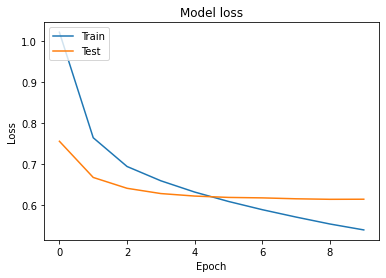

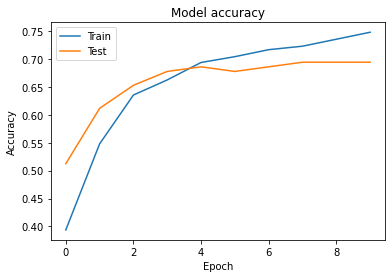

In [384]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [447]:
X = X_s
y = dataset.iloc[:,-1].values

array = y.reshape(-1, 1)

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(array).toarray()

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense# Neural network
from keras import regularizers


model = Sequential()
model.add(Dense(50, input_dim=len(X_s[0]), activation="relu",kernel_regularizer=regularizers.l2(0.1)))

#model.add(Dense(2000, activation="relu"))
model.add(Dense(100, activation="relu",kernel_regularizer=regularizers.l2(0.1)))
model.add(Dense(2, activation="softmax"))

#model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy'])


from keras.optimizers import SGD
opt = SGD(lr=0.01)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])

import time

t0 = time.process_time()


hist = model.fit(X_train, y_train,epochs=50,batch_size=50,validation_data=(X_test, y_test),verbose=1)


t_elapsed = time.process_time() - t0
print("Elapsed time =",t_elapsed)


print(hist.history['loss'])
print(hist.history['val_loss'])

print("acc",hist.history['accuracy'])
print("val_acc",hist.history['val_accuracy'])

#result = net.evaluate(x_val, y_val, batch_size=25)
#accuracy.append(result[1])

Epoch 1/50
9/9 [==============================] - 0s 20ms/step - loss: 16.9898 - accuracy: 0.6530 - val_loss: 16.6142 - val_accuracy: 0.5967
Epoch 2/50
9/9 [==============================] - 0s 5ms/step - loss: 16.3280 - accuracy: 0.7647 - val_loss: 16.0437 - val_accuracy: 0.6133
Epoch 3/50
9/9 [==============================] - 0s 5ms/step - loss: 15.7227 - accuracy: 0.7814 - val_loss: 15.5014 - val_accuracy: 0.6243
Epoch 4/50
9/9 [==============================] - 0s 4ms/step - loss: 15.1546 - accuracy: 0.8138 - val_loss: 14.9804 - val_accuracy: 0.6354
Epoch 5/50
9/9 [==============================] - 0s 5ms/step - loss: 14.6108 - accuracy: 0.8165 - val_loss: 14.4785 - val_accuracy: 0.6464
Epoch 6/50
9/9 [==============================] - 0s 4ms/step - loss: 14.0975 - accuracy: 0.8129 - val_loss: 13.9893 - val_accuracy: 0.6464
Epoch 7/50
9/9 [==============================] - 0s 5ms/step - loss: 13.5977 - accuracy: 0.8351 - val_loss: 13.5224 - val_accuracy: 0.6354
Epoch 8/50
9/9 [===

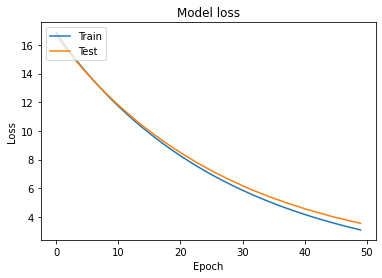

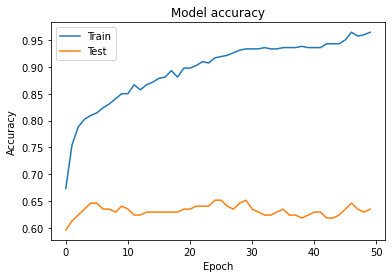

In [448]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()